# Time Scattering in Kymatio

In this tutorial we will work through examples of time scattering (Scattering1D) in Kymatio

* theory of the wavelet scattering transform of multiple orders
* understanding the scattering filterbank construction parameters (J, Q, order)
* visualizing the filters
* visualizing the response to modulated sounds that appear in music and speech
    - amplitude modulation (tremolo)
    - frequency modulation (vibrato)
    - attacks (note onset)
    - amplitude modulation interference 
* generate a dataset of synthetic signals: varying spectral shape and interference patterns
* unsupervised manifold embedding of the nearest neighbour graph (Isomap) of the dataset under Scattering1D, MFCCs and Open-L3 deep features

[Kymatio Github](https://github.com/kymatio/kymatio)

- check out xi at each order
- plot the filters at each order
- explain the transform, averaging
- show invariance to time shifts, dilations
- visualize non-averaged 1O, averaged 1O, scat 2O

### Installation

In [ ]:
!pip install kymatio

#### Import Scattering1D 
- Let's import the torch frontend. Tensorflow, Numpy and Jax are also available.

In [70]:
import numpy as np, torch
import matplotlib.pyplot as plt
from kymatio.torch import Scattering1D
from kymatio.scattering1d.filter_bank import scattering_filter_factory

#### Generate a Scattering Filterbank

First, we will use `scattering_filter_factory` to inspect the construction of a scattering filterbank

To construct the filterbank, we define the following parameters: 
* the temporal support of the filters $N$, which corresponds to the size of the input signal and must be a power of two
* the maximum scale $J$. The lowest scale (largest filter, lowest central frequency) will be defined over a time support of $2^J$. $J$ also determines the total number of octaves.
* the number of wavelets filters per octave $Q$ in the first-order filterbank. When $Q = 1$, we get a dyadic wavelet filterbank i.e. subsequent wavelet filter central frequencies are spaced by a factor two. $Q$ determines how well we can localize a signal in frequency. Smaller values of $Q$ result in filters that are wider in the frequency domain and narrower in the time domain. The choice of $Q$ depends on the application, but in general for audio higher values of $Q$ (between 4 and 16) enable better frequency localization of oscillatory signals
* $T$ the temporal support of the lowpass filter, which control the amount of imposed invariance to time-shifts. This is typically set to $2^J$ by default, but can be longer.

In [5]:
help(scattering_filter_factory)

Help on function scattering_filter_factory in module kymatio.scattering1d.filter_bank:

scattering_filter_factory(J_support, J_scattering, Q, T, r_psi=0.7071067811865476, criterion_amplitude=0.001, normalize='l1', max_subsampling=None, sigma0=0.1, alpha=4.0, P_max=5, eps=1e-07, **kwargs)
    Builds in Fourier the Morlet filters used for the scattering transform.
    
    Each single filter is provided as a dictionary with the following keys:
    * 'xi': central frequency, defaults to 0 for low-pass filters.
    * 'sigma': frequential width
    * k where k is an integer bounded below by 0. The maximal value for k
        depends on the type of filter, it is dynamically chosen depending
        on max_subsampling and the characteristics of the filters.
        Each value for k is an array (or tensor) of size 2**(J_support - k)
        containing the Fourier transform of the filter after subsampling by
        2**k
    * 'width': temporal width (interval of temporal invariance, i.e. its "

We create the filters by calling `scattering_filter_factory`. It returns the lowpass filter (phi_f), the first-order wavelet filters (psi1_f), and the second-order filters (psi2_f).

In [34]:
N = 4096
J = 8
Q = 8 
T = 2**J

phi_f, psi1_f, psi2_f = scattering_filter_factory(np.log2(N), J, Q, T)

`phi_f` is a dictionary that contains the low-pass filter at different resolutions at each integer key. For example, `phi_f[0]` is at resolution `T` while `phi_f[1]` is at resolution `T / 2`.

`psi1_f` and `psi2_f` are lists of dictionaries that contain the specifications for each wavelet bandpass filter at first and second order respectively. Each dictionary contains: 
- the filter `0`
- the filter's normalized centre frequency `xi` 
- the filter's width `sigma`
- the filter's scale `j`

In [35]:
'''temporal support of the lowpass filter at each resolution'''
[len(phi) for k, phi in phi_f.items() if type(k) is int]

[4096, 2048, 1024, 512, 256, 128, 64, 32]

In [67]:
print(f'filter 0: {psi1_f[0][0]}')
print(f'filter 0 scale: {psi1_f[0]["j"]}')
print(f'filter 0 centre frequency: {psi1_f[0]["xi"]}')
print(f'filter 0 centre frequency (Hz) {psi1_f[0]["xi"] * 4096}') # (assuming sampling rate of 4096 Hz)
print(f'filter 0 width: {psi1_f[0]["sigma"]}')

filter 0: [ 0.00000000e+00  1.04260160e-81  2.30143912e-81 ... -2.16911033e-81
 -1.57785639e-81 -8.63281387e-82]
filter 0 scale: 0
filter 0 centre frequency: 0.47835269125030533
filter 0 centre frequency (Hz) 1959.3326233612506
filter 0 width: 0.02487536135159618


### Plotting the filters

We are now ready to plot the first-order filters. We first display the lowpass filter (at full resolution) in red. We then plot each of the bandpass filters in blue (in the fourier domain). Since we don’t care about the negative frequencies, we limit the plot to the frequency interval [0, 0.5] (nyquist).

* what properties can you observe about the filters?
* how does their bandwidth change with frequency?

Text(0.5, 1.0, 'First-order filters (Q = 8)')

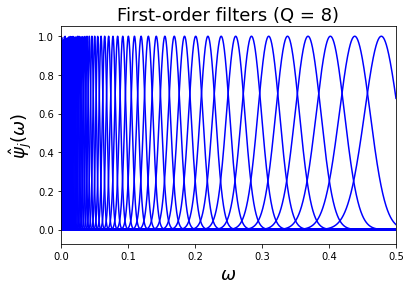

In [53]:
plt.figure()
plt.plot(np.arange(N) / N, phi_f[0], 'r')

for psi_f in psi1_f:
    plt.plot(np.arange(N)/N, psi_f[0], 'b')

plt.xlim(0, 0.5)

plt.xlabel(r'$\omega$', fontsize=18)
plt.ylabel(r'$\hat\psi_j(\omega)$', fontsize=18)
plt.title('First-order filters (Q = {})'.format(Q), fontsize=18)

Text(0.5, 1.0, 'Second-order filters (Q = 1)')

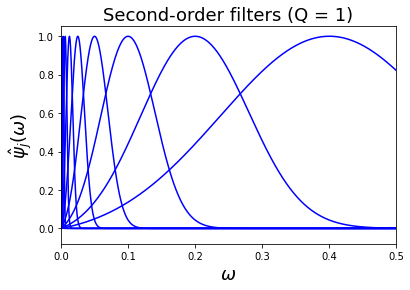

In [68]:
for psi_f in psi2_f:
    plt.plot(np.arange(N)/N, psi_f[0], 'b')

plt.xlim(0, 0.5)

plt.xlabel(r'$\omega$', fontsize=18)
plt.ylabel(r'$\hat\psi_j(\omega)$', fontsize=18)
plt.title('Second-order filters (Q = 1)', fontsize=18)

### Construct the Scattering1D frontend object

- Now we will create the scattering 1D torch frontend object. This constructs the filterbank as we did in the previous section and provides convenient methods to compute the scattering transform (`__call__`) and collect the coefficients at each order (`meta`).
- The constructor requires a specification of the maximum scale `J` and the input signal length `shape`. 
- We can also specify the number of filters per octave `Q` (default = 1), lowpass temporal support `T` (default = 2^J) and `max_order` (default = 2)

In [165]:
Fs = 2**14 # sampling rate
duration = 3 # signal duration
J = 12 # maximum wavelet scattering scale

scat1d = Scattering1D(J=J, Q=8, shape=duration * Fs)

Now, to inspect the output shape, we can compute the scattering transform of a random input. Computing the scattering transform of a signal is achieved using the __call__ method of the Scattering1D class. The output is an array of shape (C, T). C is the number of scattering coefficient outputs, and T is the number of samples along the time axis. This is typically much smaller than the number of input samples since the scattering transform performs an average in time and subsamples the result to save memory.

In [166]:
x = torch.randn(duration * Fs)
print(scat1d(x).shape)

torch.Size([547, 12])


To display the scattering coefficients, we must first identify which belong to each order (zeroth, first, or second). We do this by extracting the meta information from the scattering object and getting the indices corresponding to each order

In [167]:
meta = scat1d.meta()
order1 = np.where(meta['order'] == 0)[0]
order1 = np.where(meta['order'] == 1)[0]
order2 = np.where(meta['order'] == 2)[0]

Now we are going to construct an amplitude modulated harmonic signals. To facilitate visualization of the resulting properties of the signal, we are going to define its fundamental frequency to correspond to the centre frequency of a first-order wavelet, and the modulation frequency to correspond to the centre frequency of a second-order wavelet.

In [179]:
f0 = meta['xi'][order1[30], 0] * Fs
fm = meta['xi'][order2[9], 1] * Fs
print(f'fundamental frequency: {f0} Hz')
print(f'modulation frequency: {fm} Hz')

num_harmonics = 4
harmonics = torch.zeros(num_harmonics, duration * Fs)
t = torch.arange(0, duration, 1/Fs)

harmonics[0] = torch.sin(2 * np.pi * f0 * t)
modulator = torch.sin(2 * np.pi * fm * t)

for i in range(1, num_harmonics):
    harmonics[i] = torch.sin(2 * np.pi * (f0 * 2 ** i) * t)
    
x = torch.sum(harmonics, dim=0) # sum the harmonics
x /= torch.max(torch.abs(x)) # normalize the amplitude

fundamental frequency: 582.5130740895365 Hz
modulation frequency: 1.6 Hz


In [180]:
from IPython.display import Audio
Audio(x, rate=Fs)